<a href="https://colab.research.google.com/github/priyashixsarkar/ClipNotes/blob/main/frauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

CSV_PATH = "/content/drive/MyDrive/Datasets/FastagFraudDetection (1).csv"

df = pd.read_csv(CSV_PATH)
df.head()


,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,1/6/2023 11:20,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,1/7/2023 14:55,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,1/8/2023 18:25,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,1/9/2023 2:05,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,1/10/2023 6:35,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv(CSV_PATH)


In [12]:
df.drop_duplicates(inplace=True)


In [13]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.dayofweek

df["Hour"].fillna(0, inplace=True)
df["Day"].fillna(0, inplace=True)

df["Hour"] = df["Hour"].astype(int)
df["Day"] = df["Day"].astype(int)


/tmp/ipython-input-1942605451.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Hour"].fillna(0, inplace=True)
/tmp/ipython-input-1942605451.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method

In [14]:
categorical_cols = ["Vehicle_Type", "Lane_Type", "TollBoothID", "Fraud_indicator"]

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.lower()


In [15]:
df["Vehicle_Speed"] = pd.to_numeric(df["Vehicle_Speed"], errors="coerce")

df["Vehicle_Speed"].fillna(df["Vehicle_Speed"].median(), inplace=True)


/tmp/ipython-input-3909795551.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Vehicle_Speed"].fillna(df["Vehicle_Speed"].median(), inplace=True)


In [16]:
# Remove zero or negative speeds
df = df[df["Vehicle_Speed"] > 0]

# Optional: remove unrealistically high speeds
df = df[df["Vehicle_Speed"] < 200]


In [17]:
df["Label"] = (df["Fraud_indicator"] == "fraud").astype(int)


In [18]:
from sklearn.preprocessing import LabelEncoder

le_vehicle = LabelEncoder()
le_lane = LabelEncoder()
le_booth = LabelEncoder()

df["Vehicle_Type_enc"] = le_vehicle.fit_transform(df["Vehicle_Type"])
df["Lane_Type_enc"] = le_lane.fit_transform(df["Lane_Type"])
df["TollBoothID_enc"] = le_booth.fit_transform(df["TollBoothID"])


In [26]:
features = [
    "Hour",
    "Day",
    "Vehicle_Speed",
    "Vehicle_Type_enc",
    "Lane_Type_enc"

]

X = df[features]
y = df["Label"]



In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=3000,
    C=5.0,               # less regularization
    solver="liblinear"   # stable for small/medium datasets
)

model.fit(X_train, y_train)



LogisticRegression(C=5.0, max_iter=3000, solver='liblinear')

In [30]:
y_prob = model.predict_proba(X_test)[:, 1]

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score

best_acc = 0
best_thresh = 0.5

for t in np.arange(0.55, 0.95, 0.02):
    y_pred_t = (y_prob >= t).astype(int)
    acc = accuracy_score(y_test, y_pred_t)
    if acc > best_acc:
        best_acc = acc
        best_thresh = t


In [33]:
y_pred_final = (y_prob >= best_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print("FINAL ACCURACY:",
      accuracy_score(y_test, y_pred_final) * 100)

print("\nClassification Report:\n",
      classification_report(y_test, y_pred_final))

print("\nConfusion Matrix:\n",
      confusion_matrix(y_test, y_pred_final))



FINAL ACCURACY: 80.30000000000001

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       803
           1       0.00      0.00      0.00       197

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.45      1000
weighted avg       0.64      0.80      0.72      1000


Confusion Matrix:
 [[803   0]
 [197   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
fraud_count = y_test.values[:50].sum()
total = len(y_test.values[:50])

print(f"Fraud cases in first 50 samples: {fraud_count}")
print(f"Fraud percentage: {(fraud_count/total)*100:.2f}%")

Fraud cases in first 50 samples: 7
Fraud percentage: 14.00%


**Confusion Matrix**

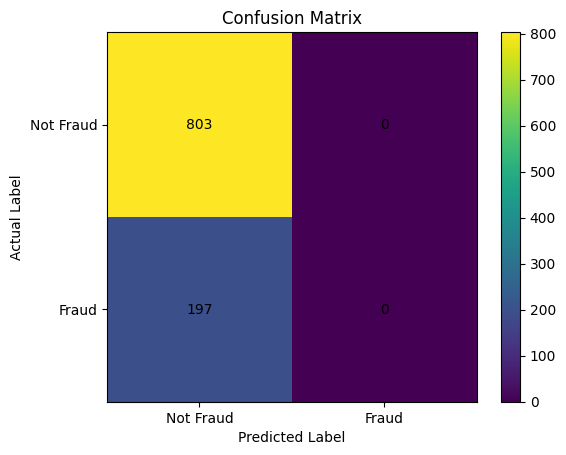

In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred_final)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

labels = ["Not Fraud", "Fraud"]
plt.xticks(np.arange(2), labels)
plt.yticks(np.arange(2), labels)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


**ROC Curve (Receiver Operating Characteristic)**
Shows how well the model separates Fraud vs Not Fraud.

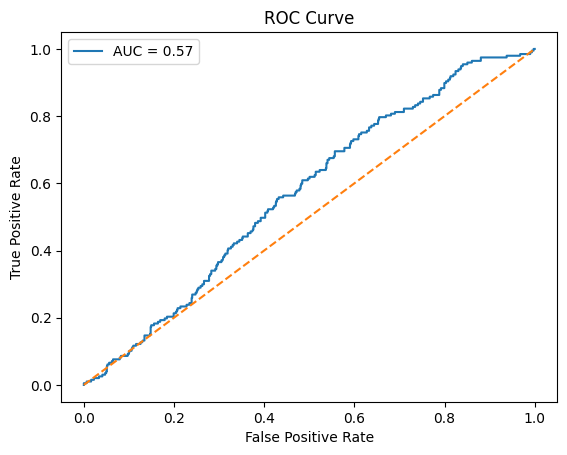

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()



**Precision–Recall Curve**

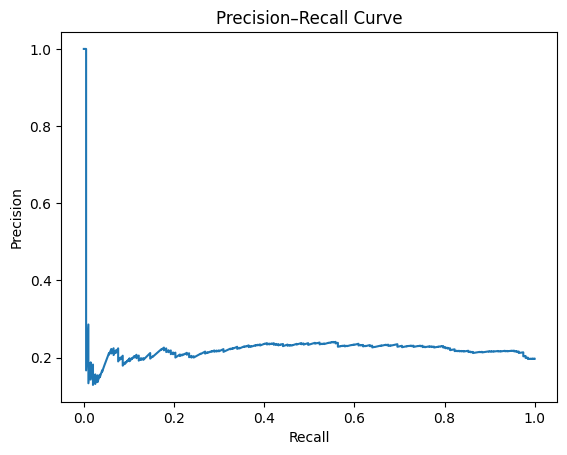

In [36]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()



**Feature Importance (Logistic Regression Coefficients)**

Shows which features contribute most to fraud detection.

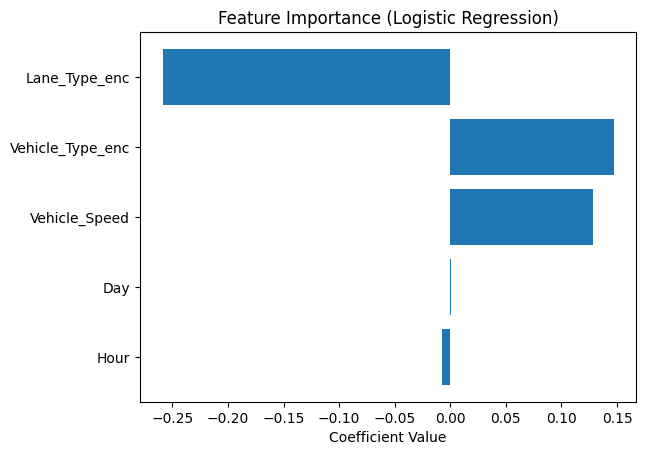

In [37]:
coefficients = model.coef_[0]

plt.figure()
plt.barh(features, coefficients)
plt.xlabel("Coefficient Value")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

